In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from scipy.stats import linregress

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, crystal, lightpath

# Prepare the crystal

In [31]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------
energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=708.2581446128465,
                              sigma_y=708.2581446128465,
                              sigma_z=1.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 2: Split
# ----------------------------------------------------------------------------------------------------------
dtheta = np.arctan(1.5 * 1e-3 / 5.)  # This is the deviation angle.
half_period = util.get_grating_period(dtheta=dtheta,
                                      klen_in=my_pulse.klen0) / 2

grating_list = [crystal.RectangleGrating(), crystal.RectangleGrating()]
grating_list[0].set_a(half_period)
grating_list[0].set_b(half_period)
grating_list[1].set_a(half_period)
grating_list[1].set_b(half_period)

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay Lines
# ----------------------------------------------------------------------------------------------------------
# Some meta data for the delay line.
h_length = 2. * np.pi / (1.9201 * 1e-4)

# Some crystal properties
chi0 = complex(-0.97631E-05, 0.14871E-06)
chih_sigma = complex(0.59310E-05, -0.14320E-06)
chihbar_sigma = complex(0.59310E-05, -0.14320E-06)
chih_pi = complex(0.46945E-05, -0.11201E-06)
chihbar_pi = complex(0.46945E-05, -0.11201E-06)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta

# Bragg angle
bragg = np.radians(18.836) + 13e-6
miscut = np.deg2rad(10.)

# Get crystal angles
eta_b1 = np.zeros(6, dtype=np.float64)
theta_b1 = np.array([np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg,
                     3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg])
rho_b1 = theta_b1 + np.pi
tau_b1 = np.array([0., miscut, -miscut, 0.,
                   -0, -0])

# Add the effect of the global rotation due to the grating momentum transfer
theta_b1 += angle_offset_1
rho_b1 += angle_offset_1

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list(num=6,
                                           hlen=np.array([h_length, ] * 6),
                                           theta=theta_b1,
                                           eta=eta_b1,
                                           rho=rho_b1,
                                           tau=tau_b1,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  2
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_2 = - dtheta
bragg = np.radians(18.836) + 13e-6

# Get crystal angles
eta_b2 = np.zeros(4, dtype=np.float64)
theta_b2 = np.array([3 * np.pi / 2. - bragg,
                     np.pi / 2. - bragg,
                     np.pi / 2. + bragg,
                     3 * np.pi / 2. + bragg])
rho_b2 = theta_b2 + np.pi
tau_b2 = np.zeros(4, dtype=np.float64)

# Add the effect of the global rotation due to the grating momentum transfer
theta_b2 += angle_offset_2
rho_b2 += angle_offset_2

# Initialize the crystals
crystal_list_2 = lclsutil.get_crystal_list(num=4,
                                           hlen=np.array([h_length, ] * 4),
                                           theta=theta_b2,
                                           eta=eta_b2,
                                           rho=rho_b2,
                                           tau=tau_b2,
                                           chi0=chi0,
                                           chih_sigma=chih_sigma,
                                           chihbar_sigma=chihbar_sigma,
                                           chih_pi=chih_pi,
                                           chihbar_pi=chihbar_pi)

# ------------------------------------------------------
#   Define the positions
# ------------------------------------------------------
path_list_fix = [5e6, 1e5, 2e5, 1.05e5, 6e6, 1e6]
path_list_var = [5e6- 2e5, 1e5, 4e5, 2e4, 3e5, 8.5e4, 6e6, 1e6]
delay_time = 100

In [32]:
for x in crystal_list_1:
    print(x.h)

[ 0.000  30967.471 -10574.726]
[ 0.000 -30967.471  10574.726]
[ 0.000 -30973.810 -10556.144]
[ 0.000  30973.810  10556.144]
[ 0.000 -30973.810 -10556.144]
[ 0.000  30973.810  10556.144]


In [33]:
for x in crystal_list_1:
    print(x.normal)

[ 0.000 -0.946  0.323]
[ 0.174  0.932 -0.318]
[-0.174  0.932  0.318]
[ 0.000 -0.947 -0.323]
[ 0.000  0.947  0.323]
[ 0.000 -0.947 -0.323]


# Adjust the crystals

In [34]:
# ---------------------------------------------------------------------------
#                  Adjust the position of the crystals
# ---------------------------------------------------------------------------

(fix_branch_path,
 kout_fixed,
 intersect_fixed,
 var_branch_path,
 kout_var,
 intersect_var) = lightpath.adjust_path_length(delay_time=delay_time,
                                               fix_branch_path=path_list_fix,
                                               fix_branch_crystal=crystal_list_2,
                                               var_branch_path=path_list_var,
                                               var_branch_crystal=crystal_list_1,
                                               grating_pair=grating_list,
                                               kin=my_pulse.k0)

# -----------------------------------------------------------------------------
#                 Update the crystals
# -----------------------------------------------------------------------------
crystal_list_1 = lclsutil.update_crystal_list(crystal_list_1,
                                              surface_points=np.copy(intersect_var[1:-2]))
crystal_list_2 = lclsutil.update_crystal_list(crystal_list_2,
                                              surface_points=np.copy(intersect_fixed[1:-2]))
grating_list[0].set_surface_point(np.copy(intersect_fixed[0]))
grating_list[1].set_surface_point(np.copy(intersect_fixed[-2]))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observation = np.copy(intersect_fixed[-1]) 
total_path = pre_length + np.sum(fix_branch_path)

print("The total propagation length is {:.2f}m.".format(total_path / 1e6))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Change frame
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
(my_pulse,
 observation,
 [crystal_list_1, 
  crystal_list_2,
  grating_list]
) = lclsutil.get_output_frame(displacement=-np.copy(intersect_fixed[-1]),
                              observe=observation,
                              pulse=my_pulse,
                              crystal_lists = [crystal_list_1, 
                                               crystal_list_2,
                                               grating_list])

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 250
number_z = 10 ** 5
kx_grid, ky_grid, kz_grid, axis_info = util.get_k_mesh_3d(number_x=number_x,
                                                          number_y=number_y,
                                                          number_z=number_z,
                                                          delta_e_x=1e-50,
                                                          delta_e_y=1e-4,
                                                          delta_e_z=1e-3 / util.c)
kz_grid += my_pulse.klen0

# Apply fft shift
# kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.ascontiguousarray(np.fft.fftshift(ky_grid))
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))

The total propagation length is 12.23m.


# Calculate the instability spacial case

In [35]:
kout = np.copy(kout_var[1])
print(kout)

a = 1e-5
b = 1e-5
c = -1e-5
misalign = [np.array([a, b, c]),
           np.array([a, b, c]),
           np.array([a, b, c]),
           np.array([a, b, c]),
           np.zeros(3),
           np.zeros(3)]


for x in range(6):
    
    rot_mat = Rotation.from_euler('xyz',misalign[x], degrees=False)
    matrix = rot_mat.as_dcm()
    
    kout, ratio = util.get_bragg_kout(kin= kout,
                                      h= matrix.dot(crystal_list_1[x].h),
                                      normal= matrix.dot(crystal_list_1[x].normal),
                                      compare_length=True)
    
    print(kout, ratio)

print(kout - grating_list[1].base_wave_vector)
print((kout - grating_list[1].base_wave_vector) / my_pulse.klen0)

[ 0.000  15.203  50677.308]
[ 0.204  30983.219  40102.741] 0.9999999999999999
[-0.082  15.203  50677.308] 1.0
[-0.077 -30960.757  40120.086] 1.0
[ 0.338  15.203  50677.308] 0.9999999999999999
[ 0.338 -30959.955  40120.705] 1.0
[ 0.338  15.203  50677.308] 1.0
[ 0.338  0.000  50677.308]
[ 0.000  0.000  1.000]


# Calculate the instability coefficient

In [36]:
# In this simulation, I would like to study the derivation across 10 urad variation.
# The num is the number of partitions I divide the 10 urad into.
num = 100
num_total = 2 * num + 1

kout_holder = np.zeros((6, 3, num_total, 3), dtype=np.float64)

for x_idx in range(6):
    for a_idx in range(3):  # The axis index
        
        eular_list = np.zeros((num_total, 3), dtype = np.float64)
        eular_list[:, a_idx] = np.arange(-num, num + 1) * 1e-5 / num

        for idx in range(num_total):

            # Define rotation matrix
            rot_mat = Rotation.from_euler('xyz', eular_list[idx], degrees=False)
            matrix = rot_mat.as_dcm()

            # Get the kout
            kout = np.copy(kout_var[1])

            for x in range(6):
                
                if x != x_idx:
                    kout, ratio = util.get_bragg_kout(kin=kout, 
                                                  h = crystal_list_1[x].h,
                                                  normal= crystal_list_1[x].normal,
                                                  compare_length=True)
                else:
                    kout, ratio = util.get_bragg_kout(kin=kout, 
                                                      h = np.dot(matrix, crystal_list_1[x].h),
                                                      normal= np.dot(matrix, crystal_list_1[x].normal),
                                                      compare_length=True)
                    
            kout_holder[x_idx, a_idx, idx, :] = kout - grating_list[1].base_wave_vector


In [37]:
kout_diff = kout_holder - kout_var[-1][np.newaxis, np.newaxis, np.newaxis, :]

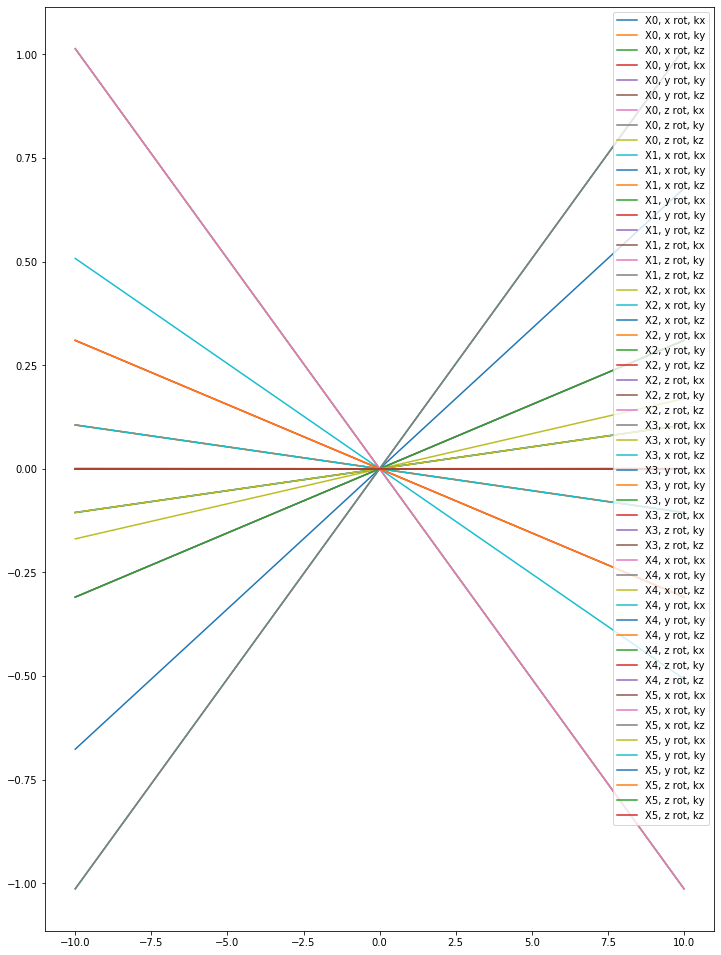

In [38]:
axis = ['x', 'y', 'z']
momen = ['kx', 'ky', 'kz']

plt.figure(figsize=(12,17))

for x_idx in range(6):
    for a_idx in range(3):
        for k_idx in range(3):
            plt.plot(np.arange(-100, 101) / 10., kout_diff[x_idx, a_idx, :, k_idx], 
                     label="X{}, {} rot, {}".format(x_idx,
                                                    axis[a_idx],
                                                    momen[k_idx]))
        
plt.legend()
plt.show()

In [39]:
gradient_holder = np.zeros((6, 3, 3))

angles = np.arange(-100, 101) / 10.  # urad

for x_idx in range(6):
    for a_idx in range(3):
        for k_idx in range(3):
        
            # Slope through the origin
            slope_o = np.dot(angles, kout_diff[x_idx, a_idx, :, k_idx]) / np.dot(angles, angles)

            # Save the gradient
            gradient_holder[x_idx, a_idx, k_idx] = slope_o

# Deviation angle for 10 urad misalignment

In [40]:
print("The deviation induced by a deviation of 10 urad misalignment on each crystal for each axis.")

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print(np.arctan(gradient_holder * 10 / my_pulse.klen0) * 1e6)

The deviation induced by a deviation of 10 urad misalignment on each crystal for each axis.
[[[ 13.351  20.000 -0.006]
  [-2.087  0.000 -0.000]
  [-6.111  0.000 -0.000]]

 [[-10.013 -20.000  0.006]
  [ 2.087  0.000 -0.000]
  [ 6.111 -0.000  0.000]]

 [[ 3.338  20.000 -0.006]
  [-2.083  0.000 -0.000]
  [ 6.112  0.000 -0.000]]

 [[ 0.000 -20.000  0.006]
  [ 2.083 -0.000 -0.000]
  [-6.112  0.000  0.000]]

 [[ 0.000  20.000 -0.006]
  [-2.083  0.000  0.000]
  [ 6.112 -0.000 -0.000]]

 [[ 0.000 -20.000  0.006]
  [ 2.083 -0.000 -0.000]
  [-6.112  0.000  0.000]]]


# Deviation when there is a static mis match in between the first two CC

When there is a static misalignment between the first two channel-cut crystals, that will not influence the result of the instability analysis. Because in the region of interest, the derivation is linear, any static misalignment will remain static and the only effect is a static stearing effect. 

The instability is essentially just the summation of the corresponding derivatives.